In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D ,  Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from pathlib import Path
import shutil
from imutils import paths
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.tensorflow
import os

In [3]:
class_name = ["Downdog","Goddess","Plank","Tree","Warrior2"]

In [4]:
class config:

    # specify the paths to datasets
    DOWNLOAD_DIR = 'YogaPoses'
    TRAIN_DIR = 'data/train'
    VAL_DIR = 'data/val'
    TEST_DIR = 'data/test'



In [5]:
dataset =tf.keras.utils.image_dataset_from_directory(
   config.DOWNLOAD_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 988 files belonging to 5 classes.


2024-08-12 16:39:05.828469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-12 16:39:05.828502: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-08-12 16:39:05.828505: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-08-12 16:39:05.828534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-12 16:39:05.828544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-08-12 16:39:06.834579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


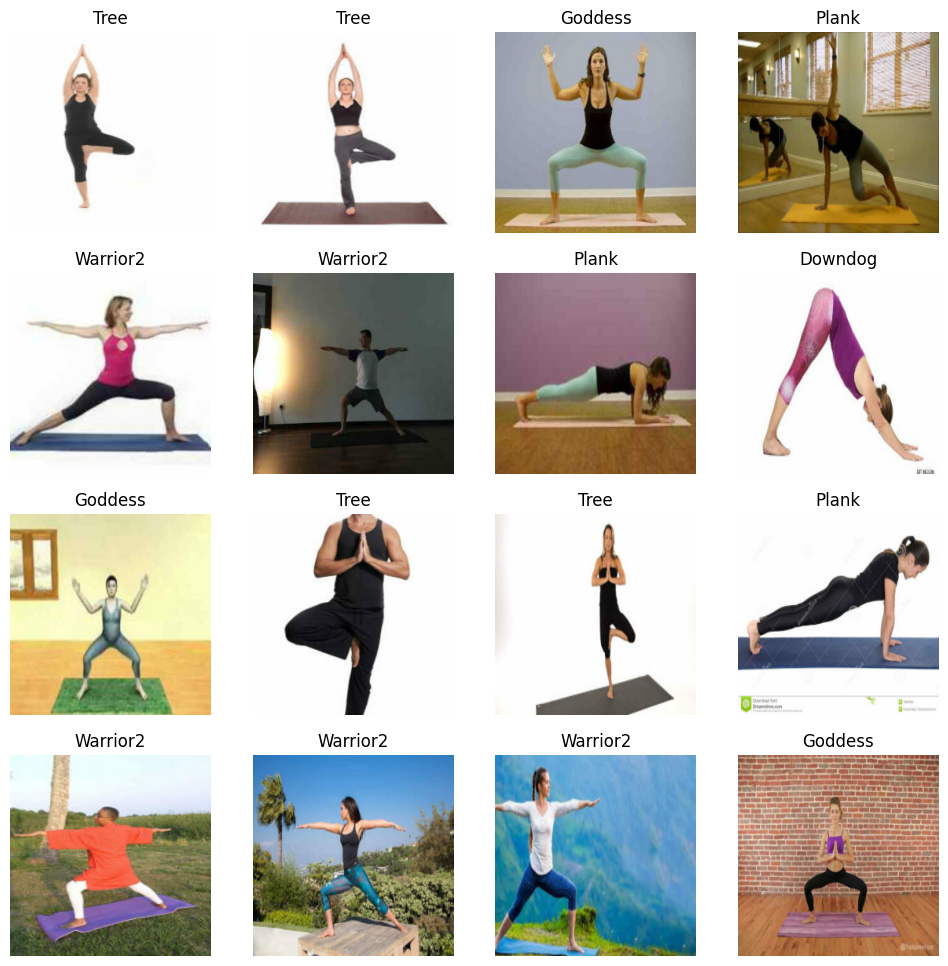

In [6]:
plt.figure(figsize = (12,12))

for images, labels in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [7]:
def split_image_folder(image_paths:str,
                folder:str):
  """
  This function creates the destination folder if it doesn't exist,
  loops over the image paths, extracts image name and label from the path,
  creates the label folder if it doesn't exist, makes the destination image 
  path and copies the current image to it.

  Parameters
  ----------
  image_paths : str
    Where the image is located
  folder : str
    train/validation path 

  """
  data_path = Path(folder)

  if not data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)

  for path in image_paths:
    full_path = Path(path)
    image_name = full_path.name
    label = full_path.parent.name
    label_folder = data_path / label

    if not label_folder.is_dir():
        label_folder.mkdir(parents=True, exist_ok=True)

    destination = label_folder / image_name
    shutil.copy(path, destination)

In [8]:
from sklearn.model_selection import train_test_split

# load all the image paths and split them into train & validation sets
print("[INFO] Getting file paths and shuffling")
image_paths = list(sorted(paths.list_images(config.DOWNLOAD_DIR)))

[INFO] Getting file paths and shuffling


In [9]:
print("[INFO] Configuring training and testing data")
class_names = [Path(x).parent.name for x in image_paths]
train_paths, rest_of_paths = train_test_split(image_paths, stratify=class_names, test_size=0.20, shuffle=True, random_state=42)

[INFO] Configuring training and testing data


In [10]:
class_names_ = [Path(x).parent.name for x in rest_of_paths]
val_paths, test_paths = train_test_split(rest_of_paths, stratify=class_names_, test_size=0.50, shuffle=True, random_state=42)

In [11]:
print("[INFO] Creating ImageFolder's for training and validation datasets")
split_image_folder(train_paths, config.TRAIN_DIR)
split_image_folder(val_paths, config.VAL_DIR)
split_image_folder(val_paths, config.TEST_DIR)

[INFO] Creating ImageFolder's for training and validation datasets


In [12]:
def create_model(base_model):
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add a dropout layer to reduce overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add another dropout layer
    x = Dense(len(class_name), activation='softmax')(x)

    # Define the new model
    model = Model(inputs=base_model.input, outputs=x)

    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss=categorical_crossentropy, metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3)])
    
    return model


In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    config.TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    config.VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)


Found 790 files belonging to 5 classes.
Found 99 files belonging to 5 classes.


In [14]:
models = [
    ("VGG16", VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))),
    ("ResNet50", ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))),
    ("InceptionV3", InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))),
    ("MobileNetV2", MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))
]

/var/folders/n_/4p37f261177fmjpv4kt7x33m0000gn/T/ipykernel_3064/2517264663.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  ("MobileNetV2", MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))


In [15]:
# Set up MLflow experiment
mlflow.set_experiment("Yoga Pose Classification3")

# Enable MLflow autologging
mlflow.tensorflow.autolog()


2024/08/12 16:39:18 INFO mlflow.tracking.fluent: Experiment with name 'Yoga Pose Classification3' does not exist. Creating a new experiment.
2024/08/12 16:39:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


[INFO] Training model: VGG16
Epoch 1/10


2024-08-12 16:39:20.071740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - categorical_accuracy: 0.3740 - loss: 3.8295 - top_k_categorical_accuracy: 0.7825 - val_categorical_accuracy: 0.8586 - val_loss: 0.5490 - val_top_k_categorical_accuracy: 0.9596
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - categorical_accuracy: 0.7687 - loss: 0.8811 - top_k_categorical_accuracy: 0.9584 - val_categorical_accuracy: 0.8990 - val_loss: 0.3594 - val_top_k_categorical_accuracy: 0.9798
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - categorical_accuracy: 0.8978 - loss: 0.3776 - top_k_categorical_accuracy: 0.9852 - val_categorical_accuracy: 0.9192 - val_loss: 0.3133 - val_top_k_categorical_accuracy: 0.9697
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - categorical_accuracy: 0.9020 - loss: 0.3100 - top_k_categorical_accuracy: 0.9869 - val_categorical_accuracy: 0.9293 - val_loss: 0.2134 - val_top_k_categorical_accuracy: 0.9899
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - categorical_accuracy: 0.9265 - loss: 

2024/08/12 16:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='881548646394477ba3196439d360258d'. Attempted logging new value 'None'.


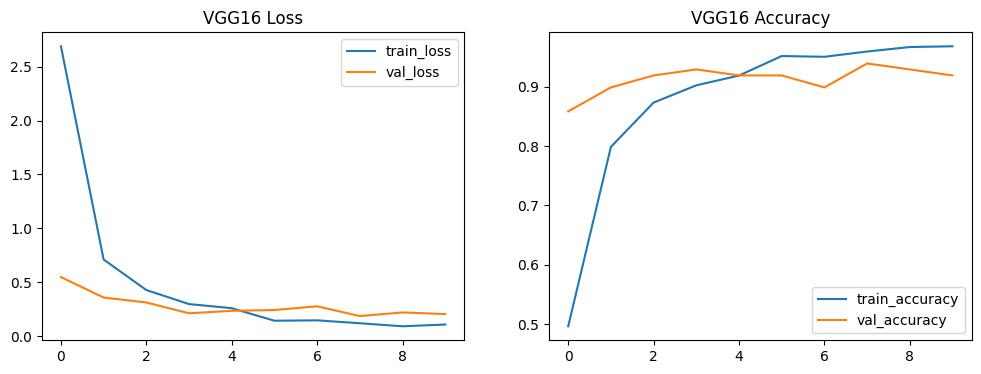

2024/08/12 16:40:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[INFO] Training model: ResNet50
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - categorical_accuracy: 0.4001 - loss: 2.1422 - top_k_categorical_accuracy: 0.7500 - val_categorical_accuracy: 0.8788 - val_loss: 0.3366 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - categorical_accuracy: 0.8071 - loss: 0.5570 - top_k_categorical_accuracy: 0.9921 - val_categorical_accuracy: 0.9293 - val_loss: 0.2641 - val_top_k_categorical_accuracy: 0.9899
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - categorical_accuracy: 0.9169 - loss: 0.2534 - top_k_categorical_accuracy: 0.9941 - val_categorical_accuracy: 0.9091 - val_loss: 0.2416 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - categorical_accuracy: 0.9469 - loss: 0.1546 - top_k_categorical_accuracy: 0.9985 - val_categorical_accuracy: 0.9394 - val_loss: 0.1913 - val_top_k_categorical_accuracy: 0.9899
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/

2024/08/12 16:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='c81672a7576a4222bc8ba7274e70a6de'. Attempted logging new value 'None'.


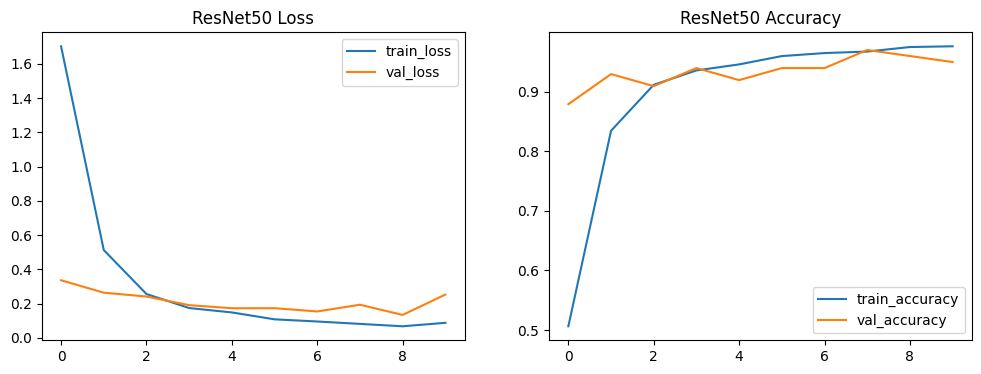

2024/08/12 16:40:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[INFO] Training model: InceptionV3
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - categorical_accuracy: 0.2050 - loss: 57.0637 - top_k_categorical_accuracy: 0.6868 - val_categorical_accuracy: 0.2727 - val_loss: 11.1973 - val_top_k_categorical_accuracy: 0.8081
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.2724 - loss: 16.8714 - top_k_categorical_accuracy: 0.6952 - val_categorical_accuracy: 0.3030 - val_loss: 2.5645 - val_top_k_categorical_accuracy: 0.7475
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - categorical_accuracy: 0.3504 - loss: 5.3776 - top_k_categorical_accuracy: 0.7449 - val_categorical_accuracy: 0.4444 - val_loss: 1.5951 - val_top_k_categorical_accuracy: 0.8081
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - categorical_accuracy: 0.3275 - loss: 3.1682 - top_k_categorical_accuracy: 0.7785 - val_categorical_accuracy: 0.4040 - val_loss: 1.2870 - val_top_k_categorical_accuracy: 0.8283
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81m

2024/08/12 16:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='e9d34d7435d34fc18a154649af04994b'. Attempted logging new value 'None'.


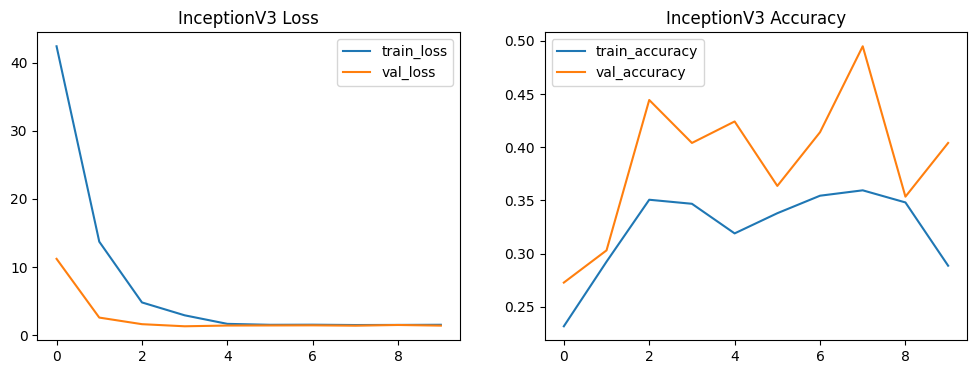

2024/08/12 16:41:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[INFO] Training model: MobileNetV2
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - categorical_accuracy: 0.3229 - loss: 1.9914 - top_k_categorical_accuracy: 0.6887 - val_categorical_accuracy: 0.5253 - val_loss: 1.1977 - val_top_k_categorical_accuracy: 0.9394
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - categorical_accuracy: 0.6024 - loss: 1.0428 - top_k_categorical_accuracy: 0.9040 - val_categorical_accuracy: 0.6970 - val_loss: 0.7679 - val_top_k_categorical_accuracy: 0.9293
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - categorical_accuracy: 0.7660 - loss: 0.6346 - top_k_categorical_accuracy: 0.9577 - val_categorical_accuracy: 0.7475 - val_loss: 0.6789 - val_top_k_categorical_accuracy: 0.9596
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - categorical_accuracy: 0.7649 - loss: 0.6232 - top_k_categorical_accuracy: 0.9664 - val_categorical_accuracy: 0.7172 - val_loss: 0.7591 - val_top_k_categorical_accuracy: 0.9495
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/st

2024/08/12 16:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='47de44473ad442d2adf1258ade2b6981'. Attempted logging new value 'None'.


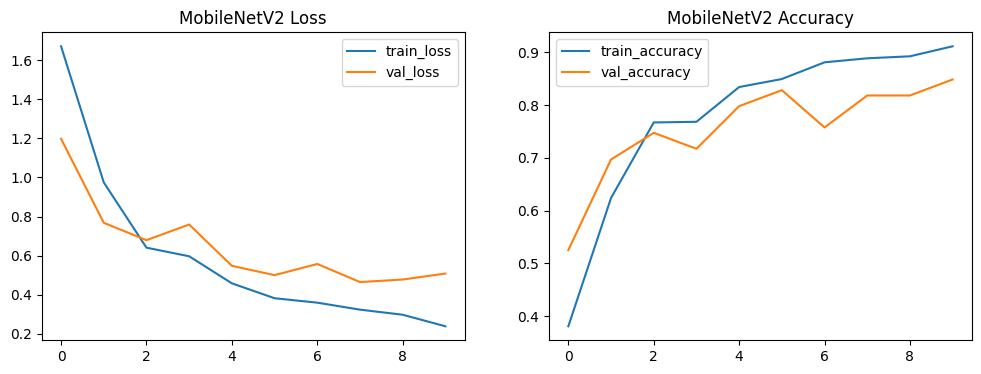

2024/08/12 16:41:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [16]:
for model_name, base_model in models:
    with mlflow.start_run(run_name=model_name):
        print(f"[INFO] Training model: {model_name}")
        model = create_model(base_model)

        # Log parameters
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", 32)
        mlflow.log_param("image_size", (256, 256))
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("optimizer", "adam")

        # Train the model and log metrics
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=10
        )

        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        final_train_accuracy = history.history['categorical_accuracy'][-1]
        final_val_accuracy = history.history['val_categorical_accuracy'][-1]
        final_top_k_categorical_accuracy = history.history['top_k_categorical_accuracy'][-1]

        mlflow.log_metric("final_train_loss", final_train_loss)
        mlflow.log_metric("final_val_loss", final_val_loss)
        mlflow.log_metric("final_train_accuracy", final_train_accuracy)
        mlflow.log_metric("final_val_accuracy", final_val_accuracy)
        mlflow.log_metric("final_top_k_categorical_accuracy", final_top_k_categorical_accuracy)

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.legend()
        plt.title(f'{model_name} Loss')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['categorical_accuracy'], label='train_accuracy')
        plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
        plt.legend()
        plt.title(f'{model_name} Accuracy')

        plt.show()

        # Log the model
        mlflow.tensorflow.log_model(model, artifact_path="models")

In [ ]:
#  mlflow ui